# 1. Nhìn vào bức tranh toàn cảnh (Look at the big picture)
Mục tiêu: Phân loại các loại trái cây trong tập dữ liệu hình ảnh với các thuật toán phân loại khác nhau, bao gồm KNN, SVM và Random Forest.

# 2. Thu thập dữ liệu (Get the data)
Chúng ta giả sử dữ liệu đã có trong thư mục data với các thư mục con train, test, và validation. Mỗi thư mục chứa các hình ảnh của các loại trái cây được dán nhãn.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical

# Đường dẫn tới các thư mục dữ liệu
train_dir = "../dataset_fruit/train"
test_dir = "../dataset_fruit/test"
validation_dir = "../dataset_fruit/validation"
batch_size = 32
img_size = (180, 180)
# Tạo ImageDataGenerators cho tập huấn luyện, kiểm tra và xác thực
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test_data = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
val_data = validation_datagen.flow_from_directory(
    validation_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# # Lưu nhãn lớp (label) để sử dụng sau
# class_labels = list(train_generator.class_indices.keys())
# print(f"Class labels: {class_labels}")

Found 3115 images belonging to 36 classes.
Found 359 images belonging to 36 classes.
Found 351 images belonging to 36 classes.


plot_precision_recall_curve

In [2]:
# hàm vẽ biểu đồ
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
def plot_precision_recall_curve(y_test_bin, y_score):
    # Compute precision and recall for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(36):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(15, 10))
    colors = [
    'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 
    'red', 'yellowgreen', 'gold', 'magenta', 'lightcoral',
    'purple', 'cyan', 'lime', 'pink', 'brown',
    'grey', 'black', 'violet', 'indigo', 'khaki',
    'salmon', 'plum', 'orchid', 'sienna', 'tan',
    'lavender', 'beige', 'peachpuff', 'chartreuse', 'coral',
    'goldenrod', 'tomato', 'chocolate', 'crimson', 'slateblue',
    'mediumseagreen', 'mediumvioletred', 'steelblue', 'lightsalmon']
    for i, color in zip(range(36), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for Fruit Data')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# 3. Khám phá và trực quan hóa dữ liệu để thu thập thông tin (Explore and visualize the data to gain insights)
Dưới đây là ví dụ để hiển thị một vài hình ảnh ngẫu nhiên từ tập huấn luyện.

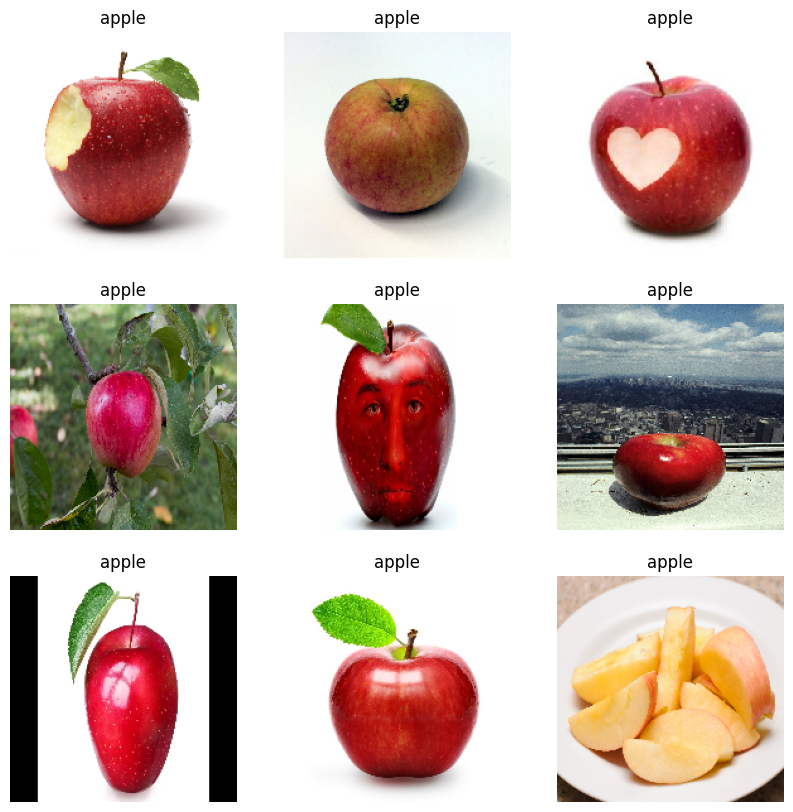

In [3]:
# Tạo ánh xạ từ nhãn số nguyên sang tên lớp
data_cat = {v: k for k, v in train_data.class_indices.items()}

# Lấy batch đầu tiên từ train_data
images, labels = next(train_data)

# Vẽ 9 ảnh đầu tiên
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(data_cat[np.argmax(labels[i])])  # Chuyển nhãn one-hot thành tên lớp
    plt.axis('off')

plt.show()

# 4. Chuẩn bị dữ liệu cho các thuật toán Machine Learning (Prepare the data for machine learning algorithms)
Trích xuất đặc trưng và nhãn từ các ảnh trong tập dữ liệu.

In [4]:
# Chuyển đổi dữ liệu thành định dạng numpy để sử dụng với các mô hình ML
def extract_features(data):
    features, labels = [], []
    for inputs_batch, labels_batch in data:
        features.append(inputs_batch)
        labels.append(labels_batch)
        if len(features) * batch_size >= data.samples:
            break
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels
# Chuẩn bị dữ liệu huấn luyện, kiểm tra, và xác thực
train_features, train_labels = extract_features(train_data)
test_features, test_labels = extract_features(test_data)
val_features, val_labels = extract_features(val_data)
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)
val_labels = np.argmax(val_labels, axis=1)
# Chuyển đổi hình ảnh thành vector 1D
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)



c:\Users\QUIN\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
#cấu trúc cnn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    # Lớp Convolutional và Pooling đầu tiên
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),  # (180x180)
    MaxPooling2D(pool_size=(2, 2)),  # Giảm (180x180) -> (90x90)

    # Lớp Convolutional và Pooling thứ hai
    Conv2D(64, (3, 3), activation='relu'),  # (90x90)
    MaxPooling2D(pool_size=(2, 2)),  # Giảm (90x90) -> (45x45)

    # Lớp Convolutional và Pooling thứ ba
    Conv2D(128, (3, 3), activation='relu'),  # (45x45)
    MaxPooling2D(pool_size=(2, 2)),  # Giảm (45x45) -> (22x22)

    # Lớp Convolutional và Pooling thứ tư
    Conv2D(256, (3, 3), activation='relu'),  # (22x22)
    MaxPooling2D(pool_size=(2, 2)),  # Giảm (22x22) -> (11x11)

    # Flatten để chuyển thành vector 1D
    Flatten()
])

model.summary()

from tensorflow.keras.models import Model

# Lấy đầu ra từ lớp Flatten
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('flatten').output)

# In cấu trúc mô hình mới
feature_extractor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

In [ ]:
# trích xuất đặc trưng bằng mạng cnn.

In [6]:

def extract_features(data_generator, feature_extractor):
    features = []
    labels = []
    for batch_images, batch_labels in data_generator:
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)
        if len(features) * data_generator.batch_size >= data_generator.samples:
            break
    features = np.vstack(features)
    labels = np.argmax(np.vstack(labels), axis=1)  # Chuyển các nhãn dạng one-hot thành dạng integer
    return features, labels

train_features_cnn, train_labels_cnn = extract_features(train_data, feature_extractor)
val_features_cnn, val_labels_cnn = extract_features(val_data, feature_extractor)
test_features_cnn, test_labels_cnn = extract_features(test_data, feature_extractor)

c:\Users\QUIN\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 228ms/step


# 5. Chọn mô hình và huấn luyện (Select a model and train it)
Huấn luyện ba mô hình KNN, SVM và Random Forest.

In [7]:
#knn
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_features, train_labels)

KNeighborsClassifier()

In [ ]:
# #svc
# svm_model = SVC(kernel='linear', C=1)
# svm_model.fit(train_features, train_labels)
# train lâu quá, lười.

In [9]:
#random forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=None)
rf_model.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=200, random_state=42)

Huấn luyện ba mô hình KNN, SVM và Random Forest với dữ liệu đã trích xuất với cnn 

In [10]:
#knn
knn_model_cnn = KNeighborsClassifier(n_neighbors=5)
knn_model_cnn.fit(train_features_cnn, train_labels)

KNeighborsClassifier()

In [11]:
# #svc
# svm_model_cnn = SVC(kernel='linear', C=1)
# svm_model_cnn.fit(train_features_cnn, train_labels)

In [12]:
#random forest
rf_model_cnn = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=None)
rf_model_cnn.fit(train_features_cnn, train_labels)

RandomForestClassifier(n_estimators=200, random_state=42)

# 6. Tinh chỉnh mô hình (Fine-tune your model)
Tối ưu hóa siêu tham số (nếu cần) bằng cách sử dụng GridSearchCV hoặc RandomizedSearchCV. Ví dụ với mô hình Random Forest:

In [13]:
# from sklearn.model_selection import GridSearchCV

# # Tinh chỉnh siêu tham số cho Random Forest
# param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
# grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy')
# grid_search.fit(train_features, train_labels)

# # In kết quả tốt nhất
# print("Best parameters for Random Forest:", grid_search.best_params_)
# rf_model = grid_search.best_estimator_


# 7. Trình bày giải pháp (Present your solution)
Đánh giá và so sánh các mô hình với các chỉ số đánh giá hiệu suất: Accuracy, Precision, Recall, và F1-score.

KNN Model:
Accuracy: 0.64
F1-Score: 0.65


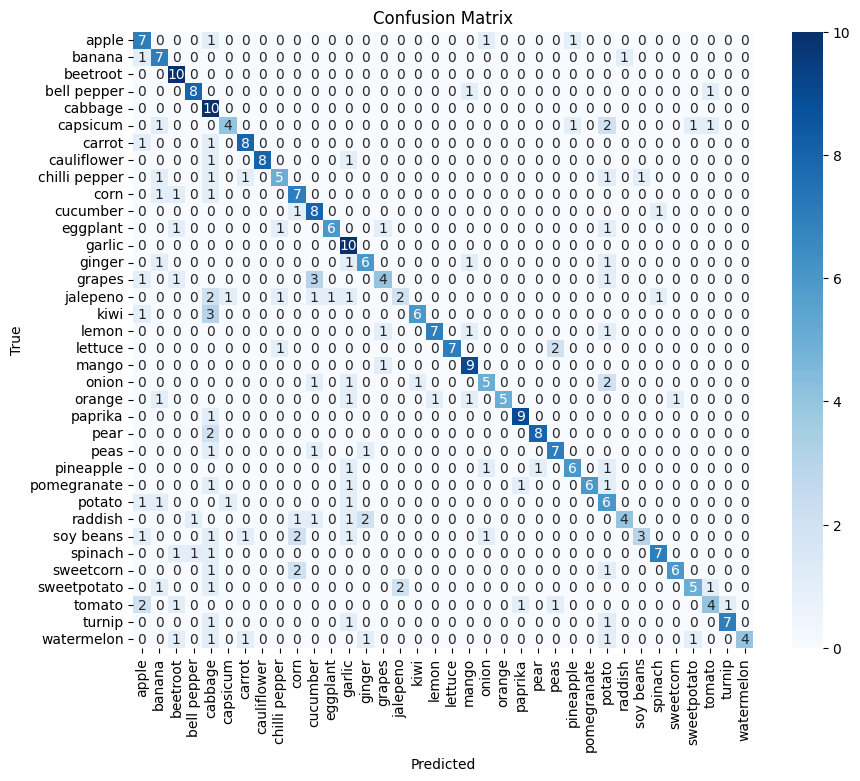

SVM Model:
Random Forest Model:
Accuracy: 0.97
F1-Score: 0.97


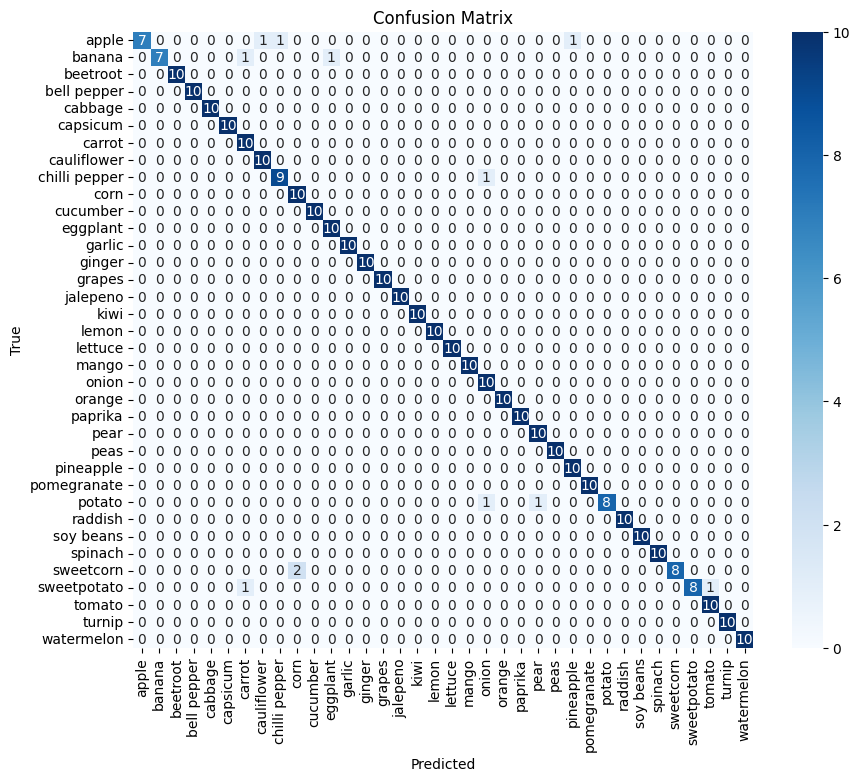

In [14]:
# Hàm đánh giá mô hình
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Accuracy: {acc:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_cat.values(), yticklabels=data_cat.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Đánh giá các mô hình
print("KNN Model:")
evaluate_model(knn_model, test_features, test_labels)

print("SVM Model:")
# evaluate_model(svm_model, test_features, test_labels)

print("Random Forest Model:")
evaluate_model(rf_model, test_features, test_labels)


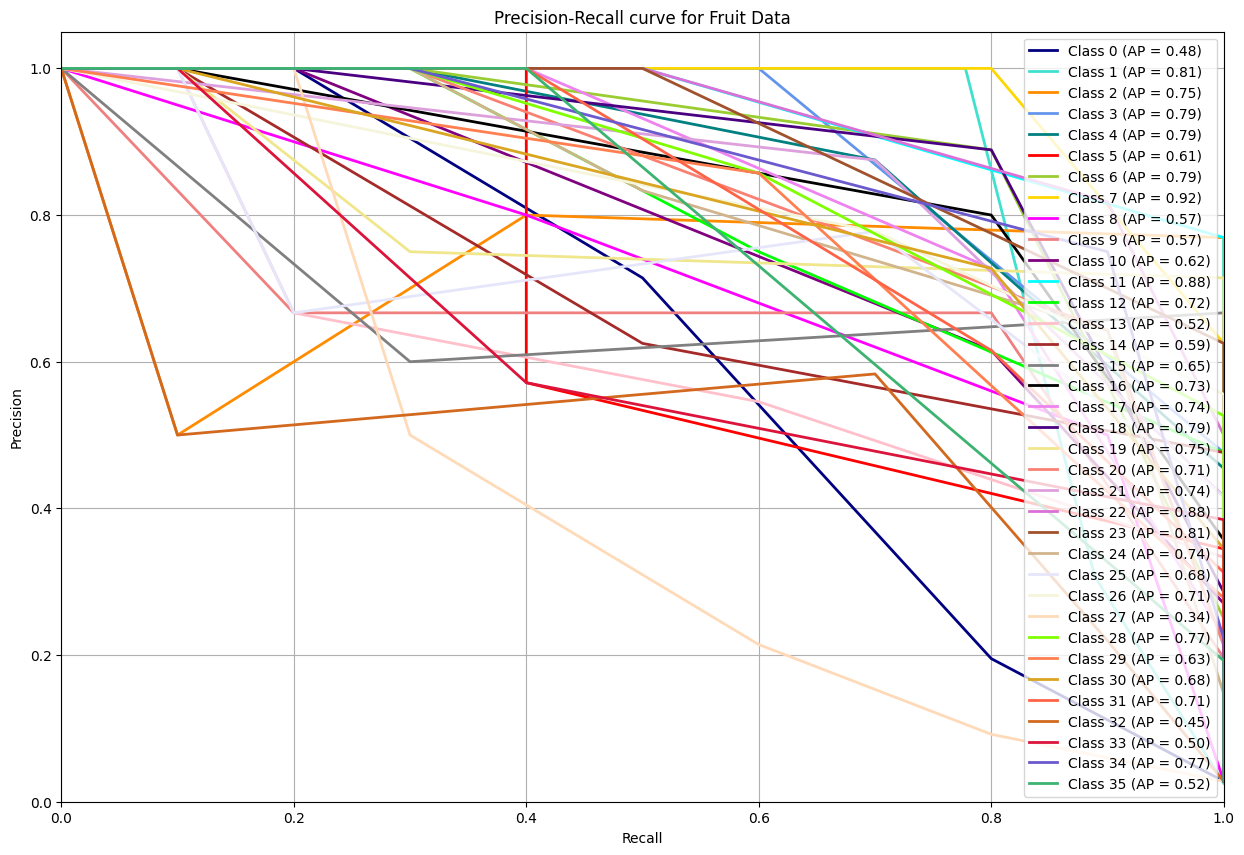

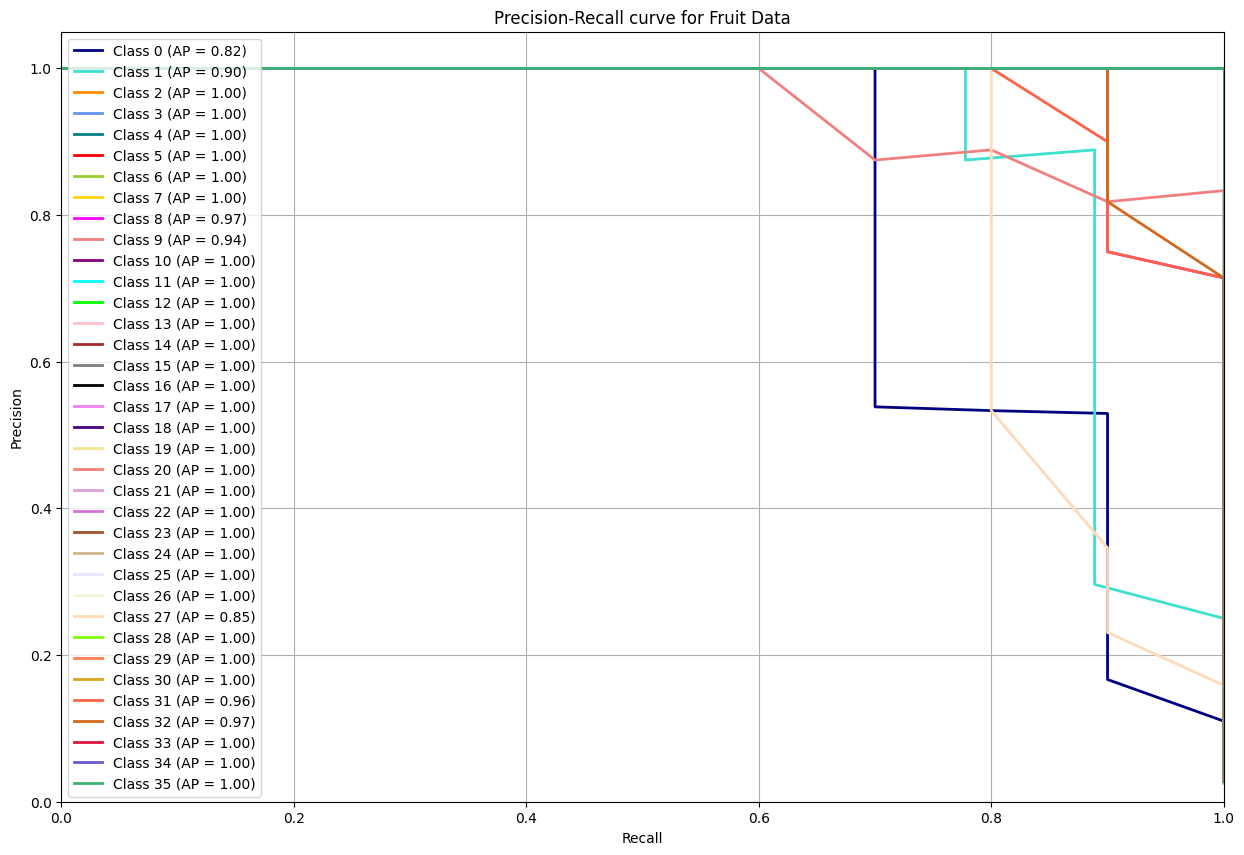

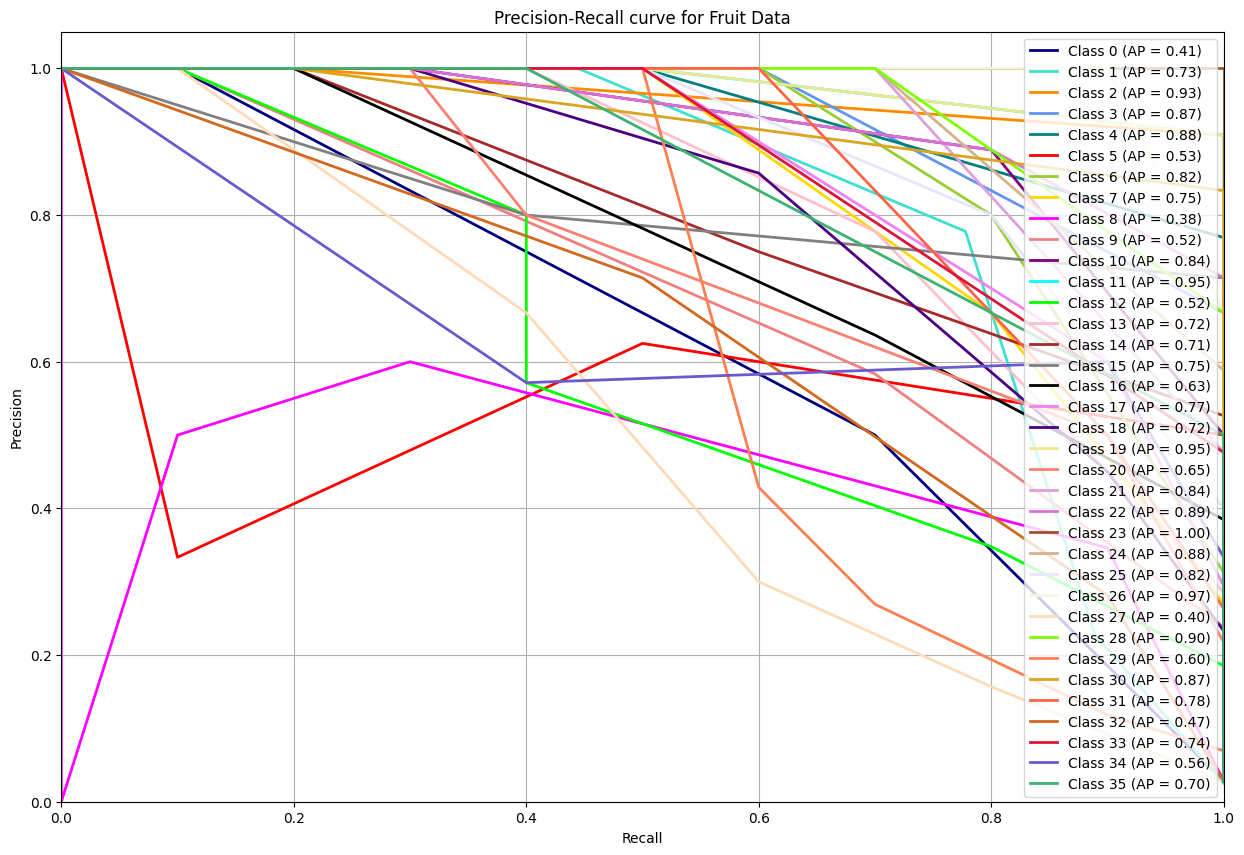

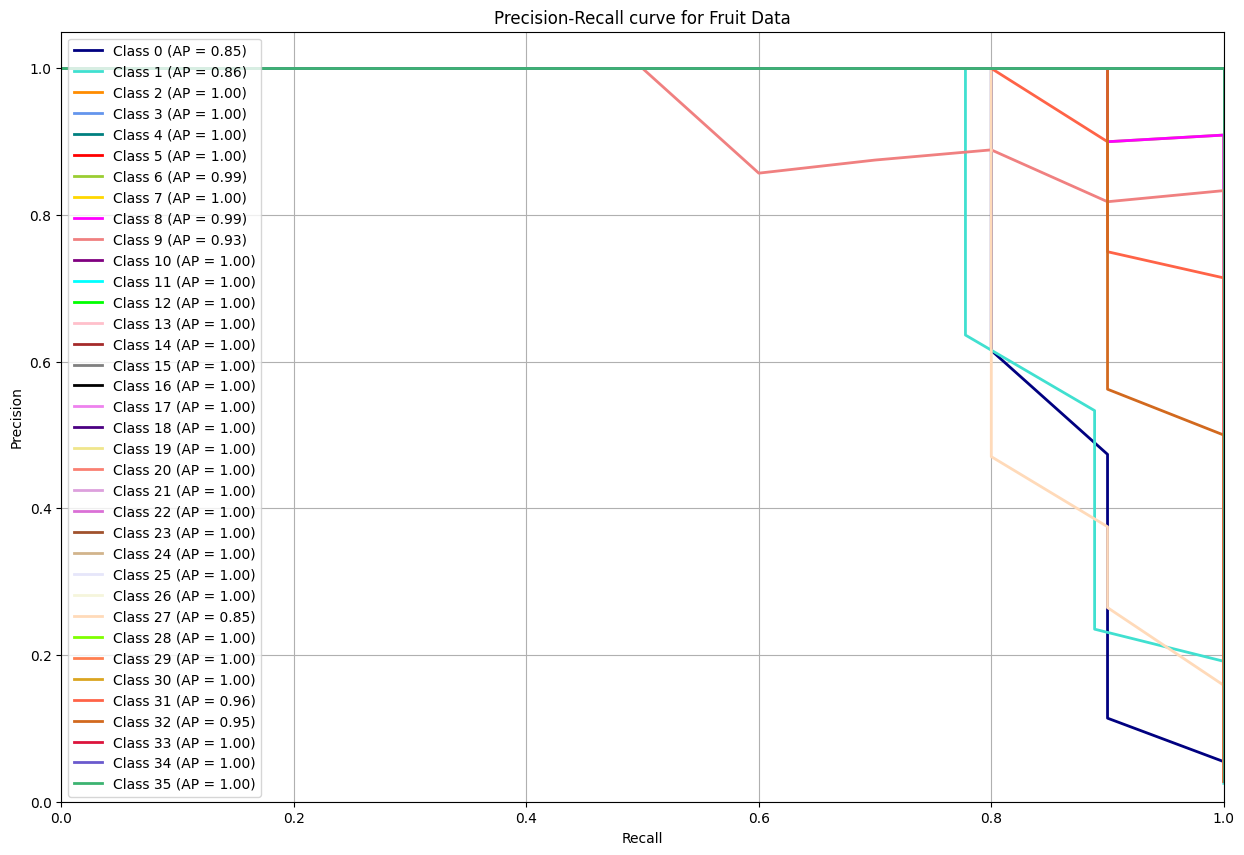

,Model,Accuracy (%),Precision (%),Recall (%),F1 Score (%)
0,KNN,64.345404,71.342339,64.345404,64.534393
1,Random Forest,96.657382,97.062547,96.657382,96.565107
2,KNN_cnn,65.738162,76.001440,65.738162,66.835218
3,Random Forest_cnn,96.935933,97.273571,96.935933,96.867752


In [15]:
import pandas as pd
from sklearn.preprocessing import label_binarize #mới thêm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
val_labels_bin = label_binarize(test_labels,classes=list(range(36))) # mới thêm
# Hàm đánh giá và lưu kết quả vào dictionary
def evaluate_model_to_dict(name, model, X_test, y_test):
    y_pred = model.predict(X_test) 
    y_score = model.predict_proba(X_test) 
    #hàm 
    plot_precision_recall_curve(val_labels_bin,y_score)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return {
        "Model": name,
        "Accuracy (%)": accuracy * 100,
        "Precision (%)": precision * 100,
        "Recall (%)": recall * 100,
        "F1 Score (%)": f1 * 100,
    }

# Đánh giá từng mô hình và thu thập kết quả
results = [
    evaluate_model_to_dict("KNN", knn_model, test_features, test_labels),
    # evaluate_model_to_dict("SVM", svm_model, test_features, test_labels),
    evaluate_model_to_dict("Random Forest", rf_model, test_features, test_labels),
    evaluate_model_to_dict("KNN_cnn", knn_model_cnn, test_features_cnn, test_labels),
    # evaluate_model_to_dict("SVM_cnn", svm_model_cnn, test_features_cnn, test_labels),
    evaluate_model_to_dict("Random Forest_cnn", rf_model_cnn, test_features_cnn, test_labels),
]

# Chuyển đổi danh sách kết quả thành DataFrame
results_df = pd.DataFrame(results)

# Hiển thị bảng
display(results_df)


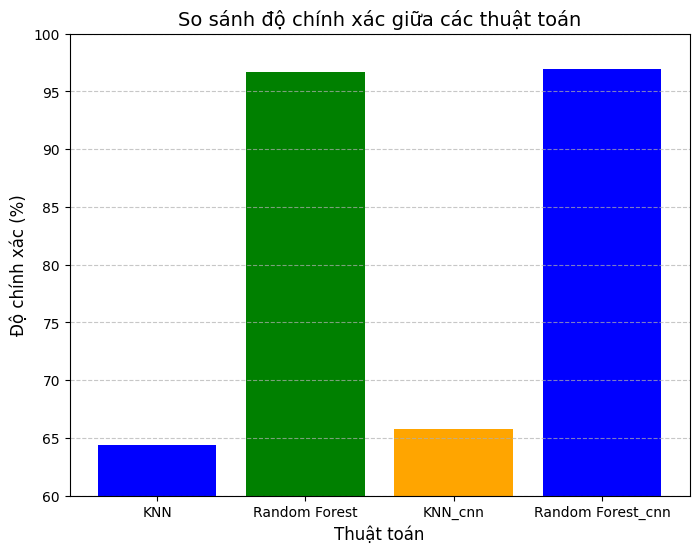

In [16]:
# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(8, 6))
plt.bar(results_df['Model'], results_df['Accuracy (%)'], color=['blue', 'green', 'orange'])
plt.title('So sánh độ chính xác giữa các thuật toán', fontsize=14)
plt.ylabel('Độ chính xác (%)', fontsize=12)
plt.xlabel('Thuật toán', fontsize=12)
plt.ylim(60, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

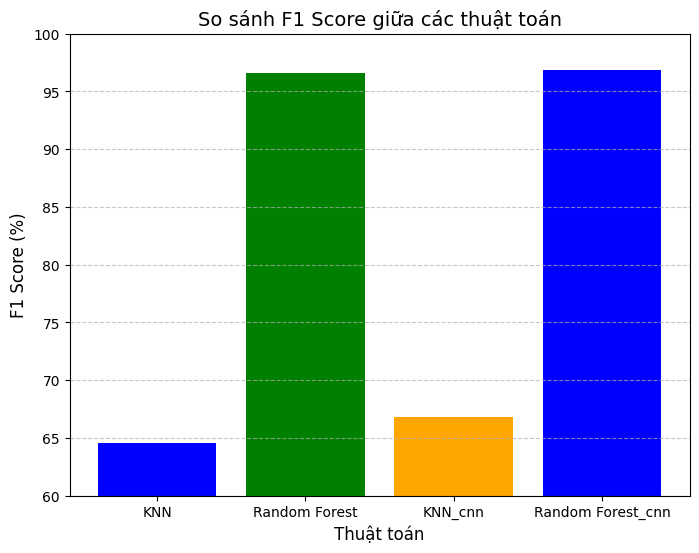

In [17]:
# Vẽ biểu đồ F1 Score
plt.figure(figsize=(8, 6))
plt.bar(results_df['Model'], results_df['F1 Score (%)'], color=['blue', 'green', 'orange'])
plt.title('So sánh F1 Score giữa các thuật toán', fontsize=14)
plt.ylabel('F1 Score (%)', fontsize=12)
plt.xlabel('Thuật toán', fontsize=12)
plt.ylim(60, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 8. Triển khai, giám sát và bảo trì hệ thống (Launch, monitor, and maintain your system)
Lưu các mô hình đã huấn luyện để sử dụng cho triển khai:

In [18]:
import joblib

# Lưu mô hình
joblib.dump(knn_model, "models/knn_model.pkl")
joblib.dump(svm_model, "models/svm_model.pkl")
joblib.dump(rf_model, "models/random_forest_model.pkl")

print("Models saved successfully!")

FileNotFoundError: [Errno 2] No such file or directory: 'models/knn_model.pkl'